In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-airbnb-open-data/AB_US_2020.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [3]:
df=pd.read_csv("/kaggle/input/us-airbnb-open-data/AB_US_2020.csv")
df.dtypes

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
dtype: object

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


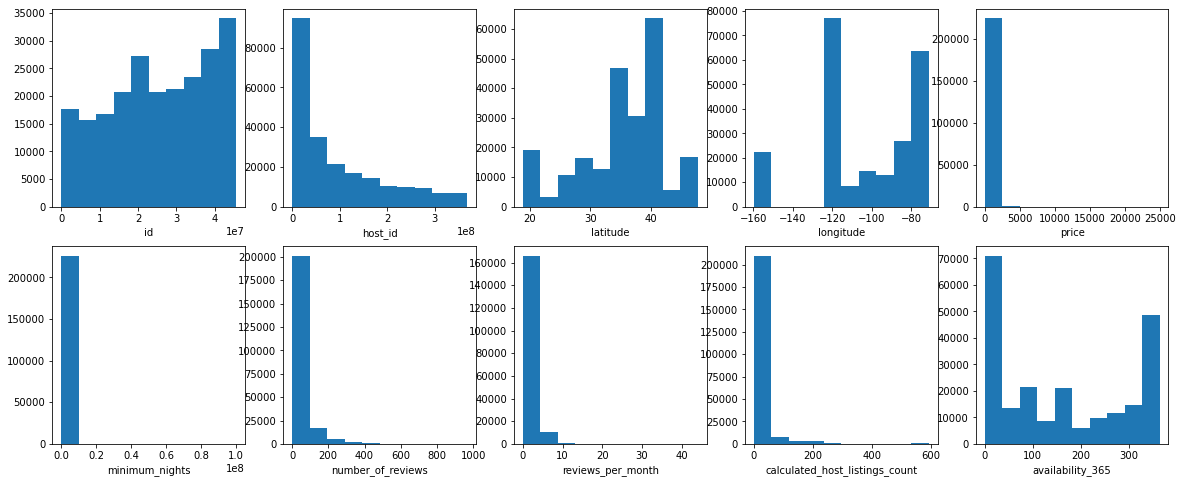

In [4]:
rows=2
cols=5
fig,ax=plt.subplots(rows,cols,figsize=(20,8))
d=df.select_dtypes(include=['float64','int64']).columns
for row in range(rows):
    for col in range(cols):
        ax[row,col].hist(df[d[cols*row+col]])
        ax[row,col].set_xlabel(d[cols*row+col])
plt.show()   

# Outlier removal                
Removing the outliers from the price column. As most of the listings have price less than 200 and more than 40 we remove the other listings for better predictions when trying to predict the price per night for the listings.

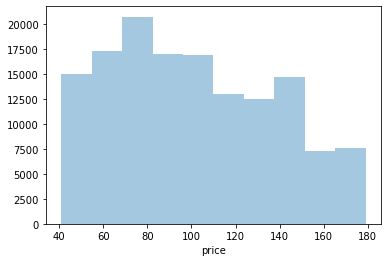

In [5]:
sns.distplot(df[(df['price']<180) & (df['price']>40)]['price'],kde=False,bins=10)

In [6]:
df=df[(df['price']<180) & (df['price']>40)]
len(df)

142294

There are still enough listings for us to train a model and predict the prices.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


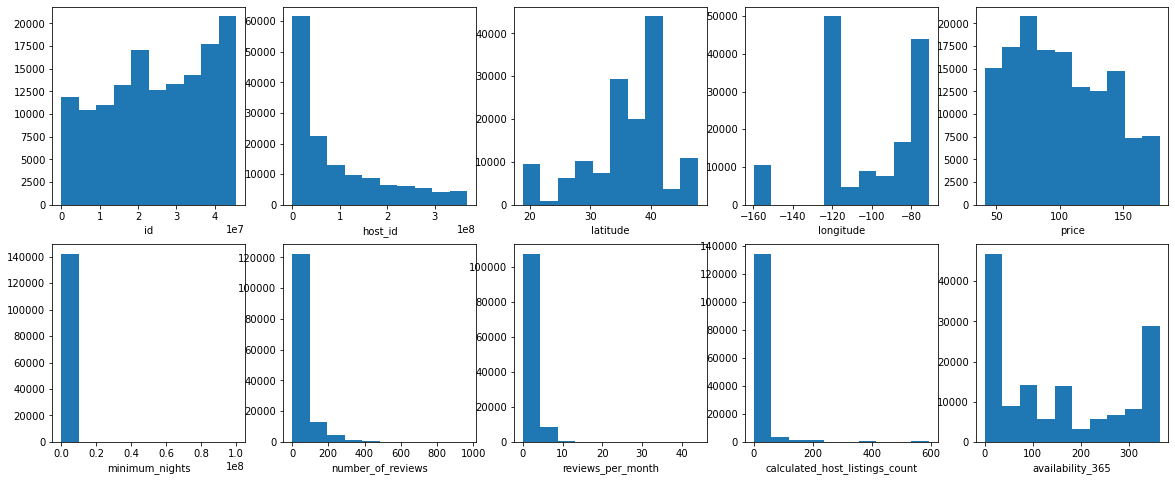

In [7]:
rows=2
cols=5
fig,ax=plt.subplots(rows,cols,figsize=(20,8))
d=df.select_dtypes(include=['float64','int64']).columns
for row in range(rows):
    for col in range(cols):
        ax[row,col].hist(df[d[cols*row+col]])
        ax[row,col].set_xlabel(d[cols*row+col])
plt.show()   

Now the price values are much more evenly distributed and hence we can get fair predictions from our model.

In [8]:
city=df.groupby('city').agg({'id':'count','price':np.mean,'number_of_reviews':['sum',np.mean],'availability_365':np.mean})
city.head()

id       price number_of_reviews            availability_365
               count        mean               sum       mean             mean
city                                                                          
Asheville       1436  103.184540            135234  94.174095       151.314763
Austin          5908  101.349695            232927  39.425694       133.937204
Boston          2205  107.411338             93507  42.406803       179.898413
Broward County  6306  101.910561            164041  26.013479       189.875198
Cambridge        706  104.787535             34990  49.560907       135.339943

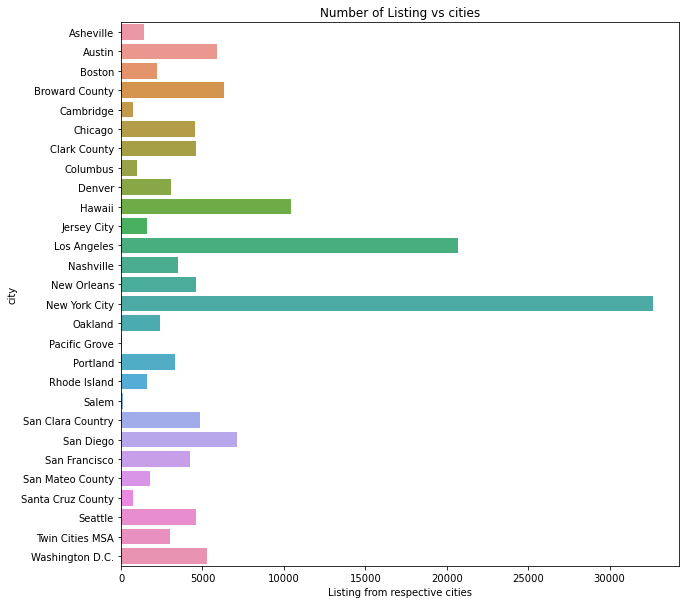

In [9]:
fig=plt.figure(figsize=(10,10))
ax=sns.barplot(y=city.index,x=city.id['count'])
ax.set_xlabel('Listing from respective cities')
ax.set_title('Number of Listing vs cities')
plt.show()

New York city clearly stands out in the total number of listings from a respective city.

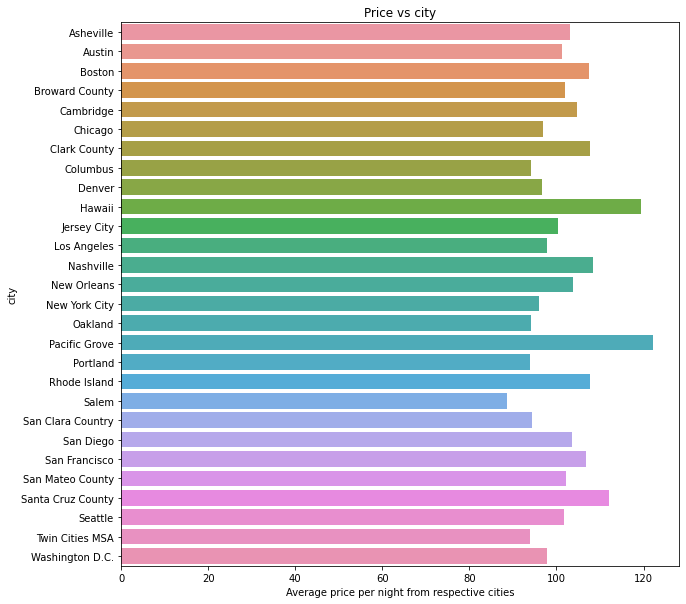

In [10]:
fig=plt.figure(figsize=(10,10))
ax=sns.barplot(y=city.index,x=city.price['mean'])
ax.set_xlabel('Average price per night from respective cities')
ax.set_title('Price vs city')
plt.show()

The prices are fairly evenly distributed given that we have already removed the outliers.

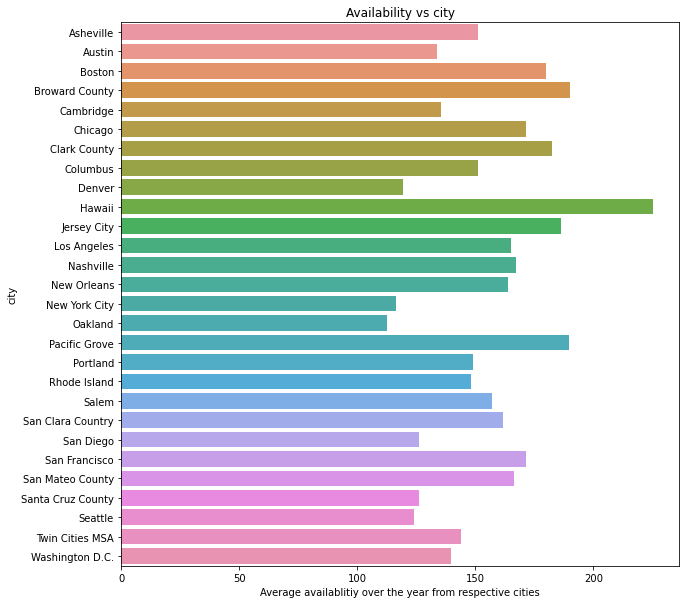

In [11]:
fig=plt.figure(figsize=(10,10))
ax=sns.barplot(y=city.index,x=city.availability_365['mean'])
ax.set_xlabel('Average availablitiy over the year from respective cities')
ax.set_title('Availability vs city')
plt.show()

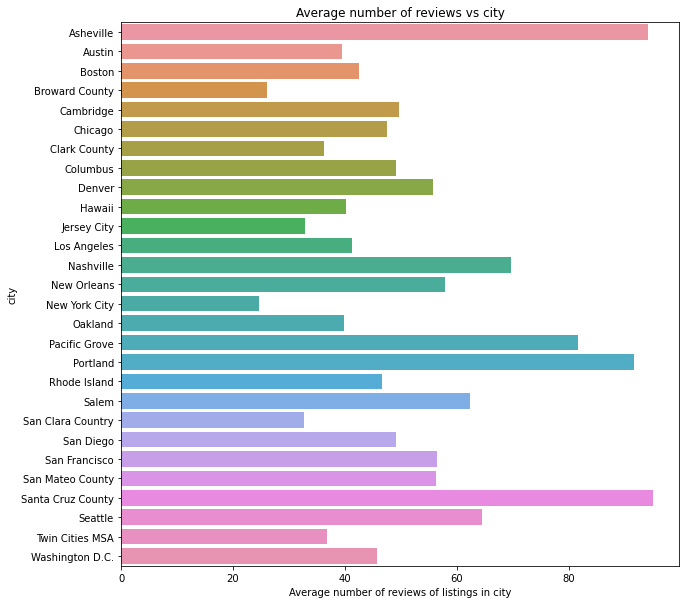

In [12]:
fig=plt.figure(figsize=(10,10))
ax=sns.barplot(y=city.index,x=city.number_of_reviews['mean'])
ax.set_xlabel('Average number of reviews of listings in city')
ax.set_title('Average number of reviews vs city')
plt.show()

In [13]:
states_dic = {'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA','Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI','Jersey City':'NJ',
             'Los Angeles':'SC','Nashville':'TN','New Orleans':'MS','New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR','Rhode Island':'RI','Salem':'MA','San Clara Country':'CA',
             'Santa Cruz County':'CA','San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA','Twin Cities MSA':'MN','Washington D.C.':'DC'}
df['States']=df['city'].apply(lambda x: states_dic[x])

In [14]:
states=df.groupby("States").agg({'id':'count','price':np.mean,'number_of_reviews':['sum',np.mean],'availability_365':np.mean})

In [15]:
fig=ex.choropleth(locations=states.index,color=states.price['mean'],locationmode='USA-states',title="Average Airbnb price of listings from states",scope='usa',color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [16]:
fig=ex.choropleth(locations=states.index,color=states.number_of_reviews['mean'],locationmode='USA-states',title="Average reviews of listings from states",scope='usa',color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [17]:
words=[]
for sentence in df['name'].astype("str"):
    s=sentence.split(" ")
    words.extend(s)
stopwords=set(STOPWORDS)
words=" ".join(words)                                    

(-0.5, 399.5, 199.5, -0.5)

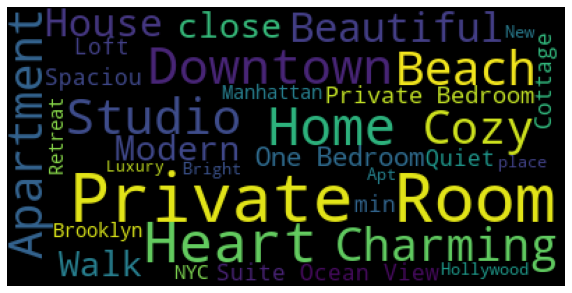

In [18]:
wordcloud=WordCloud(stopwords=stopwords,min_font_size=10).generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')

In [19]:
from tensorflow.keras.preprocessing.text import one_hot,text_to_word_sequence,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,Bidirectional
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import RandomForestRegressor
import nltk
import re 

In [20]:
df['nlp_text']=df['name']+" "+df['room_type']
df['nlp_text']=df['nlp_text'].astype('str').apply(lambda x:x.lower())  #converting to lower case
df['nlp_text']=[re.sub('[^A-Za-z]'," ",x) for x in df['nlp_text']] #removing characters other than alphabets

In [21]:
def remove_stopwords(x):
    h=[]
    x=x.split(" ")
    STOP=stopwords.words("english")
    h=[j for j in x if j not in STOP]
    return " ".join(h)
df['nlp_text']=df['nlp_text'].apply(lambda x:remove_stopwords(x)) #removing the most common words 

In [22]:
s=set()
for x in df['nlp_text']:
    words=x.split(" ")
    for y in words:
        s.add(y)
print("Total number of unique words :",len(s)) 

Total number of unique words : 17087


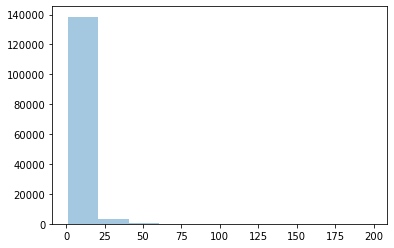

In [23]:
lengths=[len(x.split(" ")) for x in df['nlp_text']] 
sns.distplot(lengths,kde=False,bins=10)

Most of the listing contain between 0 and 25 words in the name.

In [24]:
np.mean(lengths)

10.434818052763996

In [25]:
tokenizer=Tokenizer(num_words=25000)
tokenizer.fit_on_texts(s)
sequences=tokenizer.texts_to_sequences(df['nlp_text'])
input_len=10 #keeping only the first 10 words 
sequences=pad_sequences(sequences,input_len,padding='post',truncating='post')

In [26]:
model=Sequential()
model.add(Embedding(25000,64,input_length=input_len))
model.add(Flatten())
model.add(Dense(480,activation='relu'))
model.add(Dense(1))

In [27]:
test=sequences[120000:]
train=sequences[:120000]
y_train=df['price'][:120000]
y_test=df['price'][120000:]

In [28]:
model.compile(metrics='mae',optimizer='adam',loss='mse')
model.fit(train,y_train,epochs=5,batch_size=150,validation_split=0.3)

Epoch 1/5
560/560 [==============================] - 10s 18ms/step - loss: 1943.8378 - mae: 33.0862 - val_loss: 939.0046 - val_mae: 24.3880
Epoch 2/5
560/560 [==============================] - 9s 16ms/step - loss: 903.4960 - mae: 24.1965 - val_loss: 938.5691 - val_mae: 24.4890
Epoch 3/5
560/560 [==============================] - 10s 17ms/step - loss: 833.1550 - mae: 23.0126 - val_loss: 964.6421 - val_mae: 25.0023
Epoch 4/5
560/560 [==============================] - 10s 18ms/step - loss: 778.3094 - mae: 22.0272 - val_loss: 986.8499 - val_mae: 24.9983
Epoch 5/5
560/560 [==============================] - 10s 17ms/step - loss: 737.6111 - mae: 21.2590 - val_loss: 1022.4337 - val_mae: 25.4105


In [29]:
test_set=df.iloc[120000:]
test_set['predicted']=model.predict(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
mean_absolute_error(test_set['price'],test_set['predicted'])

27.23894397857596

In [31]:
df2=df[['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','room_type','city']]

In [32]:
dummy=pd.get_dummies(df2[['room_type','city']])
df2=pd.merge(df2,dummy,right_index=True,left_index=True)

In [33]:
df2.drop(['room_type','city'],axis=1,inplace=True)
y=df['price']
df2.replace({np.nan:0},inplace=True)

In [34]:
X_train=df2.iloc[:120000]
X_test=df2.iloc[120000:]
y_train=df['price'][:120000]
y_test=df['price'][120000:]

In [35]:
forest=RandomForestRegressor(max_depth=10,n_estimators=250)
forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=250)

In [36]:
test_set['forest_predicted']=forest.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
mean_absolute_error(test_set['forest_predicted'],y_test)

26.71441086295446

In [38]:
test_set['average_prediction']=0.5*test_set['forest_predicted']+0.5*test_set['predicted']
mean_absolute_error(test_set['average_prediction'],test_set['price'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



25.956092439162514

Hence we can say that the actual price per night for the listing could be 26 more or less than the predicted value.

In [39]:
test_set.iloc[:15][['price','predicted','forest_predicted','average_prediction']]

,price,predicted,forest_predicted,average_prediction
189407,90,76.935219,103.488749,90.211984
189408,120,91.597099,117.419112,104.508106
189409,168,117.099594,110.088355,113.593974
189410,150,109.472565,106.903636,108.188100
189413,100,103.196457,113.337271,108.266864
189418,50,62.562687,70.699402,66.631045
189419,70,75.426758,76.670640,76.048699
189422,149,118.594200,137.541357,128.067779
189423,149,106.888901,137.541357,122.215129
189424,149,103.294083,137.541357,120.417720


In [40]:
mean_squared_error(test_set['average_prediction'],test_set['price'])**0.5

32.24833626334875

In [41]:
test_set.to_csv("output1.csv",index=False)